In [1]:
import os
import glob
import hydromt
import pandas as pd
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import scipy.io as sio
import sys

sys.path.append(r'C:\Users\lelise\Documents\GitHub\flood_model_carolinas\syntheticTCs_cmpdfld')
from src.utils import track_points_to_linestring

In [2]:
# Load in the data catalogs needed for building the model
os.chdir(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter3_SyntheticTCs')
yml_base = r'Z:\Data-Expansion\users\lelise\data\data_catalog_BASE_Carolinas.yml'
sfincs_mod = SfincsModel(root=r'.\03_MODEL\sfincs_base_mod', mode='r', data_libs=yml_base)

In [3]:
# Load the TC Track file
fname = r'.\02_DATA\NCEP_Reanalysis\tracks\UScoast6_AL_ncep_reanal_roEst1rmEst1_trk100'
tc_tracks = sio.loadmat(f'{fname}.mat')
tc_tracks_polyline = track_points_to_linestring(tc_tracks, output_shpfile=None)

In [24]:
# Change the directory to the model results
results_dir = r'.\04_RESULTS\ncep'
runs_dir = r'.\03_MODEL\ncep_runs\completed_runs'
zsmax_da = xr.open_dataarray(os.path.join(results_dir, 'zsmax_VmaxLf_83_165.nc'))
zsmax_ds = zsmax_da.to_dataset(dim='scenario')
attr_ds = xr.open_dataset(os.path.join(results_dir, 'attribution_VmaxLf_83_165.nc'))

tc_ids = zsmax_ds.tc_id.values
tc_id = tc_ids[0] 

# Get storm track
tc_track_gdf = tc_tracks_polyline[tc_tracks_polyline['tc_id'] == tc_id]
tc_track_gdf = tc_track_gdf.to_crs(32617)
region = sfincs_mod.region

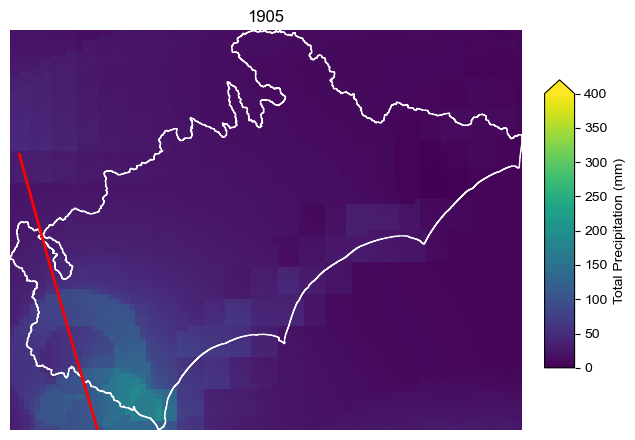

In [47]:
# Load precip boundary condition
precip_filepath = os.path.join(runs_dir, f'TC_{str(tc_id).zfill(4)}', 'sfincs_bc_inputs', 'precip_2d.nc')
precip = sfincs_mod.data_catalog.get_rasterdataset(precip_filepath)

# Plot 
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)

fig, ax = plt.subplots(tight_layout=True, figsize=(6, 4.5))
ckwargs = dict(vmin=0, vmax=400)
cs = precip.sum(dim='time').plot(ax=ax, add_colorbar=False, **ckwargs, zorder=0)
region.plot(ax=ax, color='none', edgecolor='white', linewidth=1, zorder=1, alpha=1)
tc_track_gdf.geometry.plot(ax=ax, color='red', linewidth=2, zorder=2)

# Set figure extents
minx, miny, maxx, maxy = region.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add colorbar
pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 + 0.075, pos0.y0 + 0.05, 0.05, pos0.height * 0.8])
cbar = fig.colorbar(cs, cax=cax, orientation='vertical', label='Total Precipitation (mm)', extend='max')

ax.set_axis_off()
ax.set_title(f'{tc_id}')
plt.margins(x=0, y=0)
plt.savefig(os.path.join(runs_dir, f'TC_{str(tc_id).zfill(4)}', 'total_precip.png'), dpi=225, bbox_inches="tight")

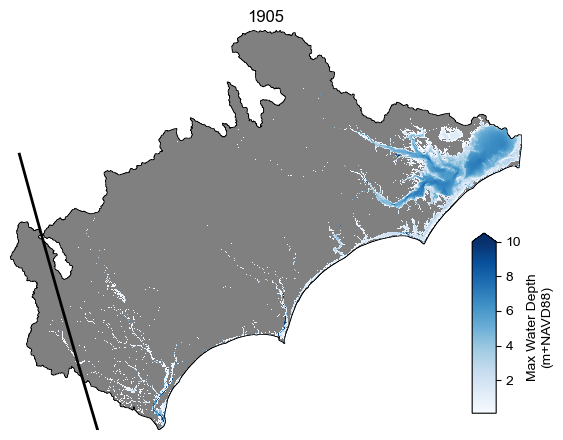

In [48]:
'''Plot 1: Peak Flood Depth - Compound '''
zsmax = zsmax_ds.sel(tc_id=tc_id)['compound']
dem = sfincs_mod.grid['dep']
hmax = zsmax - dem
hmax = hmax.where(hmax > 0.1)

fig, ax = plt.subplots(tight_layout=True, figsize=(6, 4.5))
# Plot difference in water level raster
ckwargs = dict(cmap='Blues', vmin=0.1, vmax=10)
cs = hmax.plot(ax=ax, add_colorbar=False, **ckwargs, zorder=2)

# Plot background/geography layers
region.plot(ax=ax, color='grey', edgecolor='none', linewidth=0.5, zorder=1, alpha=1)
region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=2, alpha=1)
tc_track_gdf.geometry.plot(ax=ax, color='black', linewidth=2, zorder=2)

minx, miny, maxx, maxy = region.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 - 0.05, pos0.y0 + -0.05, 0.04, pos0.height * 0.5])
label = 'Max Water Depth\n(m+NAVD88)'
cbar = fig.colorbar(cs, cax=cax, orientation='vertical', label=label, extend='max')
ax.set_title(f'{}')
ax.set_axis_off()
plt.margins(x=0, y=0)
plt.savefig(os.path.join(runs_dir, f'TC_{str(tc_id).zfill(4)}', 'max_depth.png'), dpi=225, bbox_inches="tight")
#plt.close()

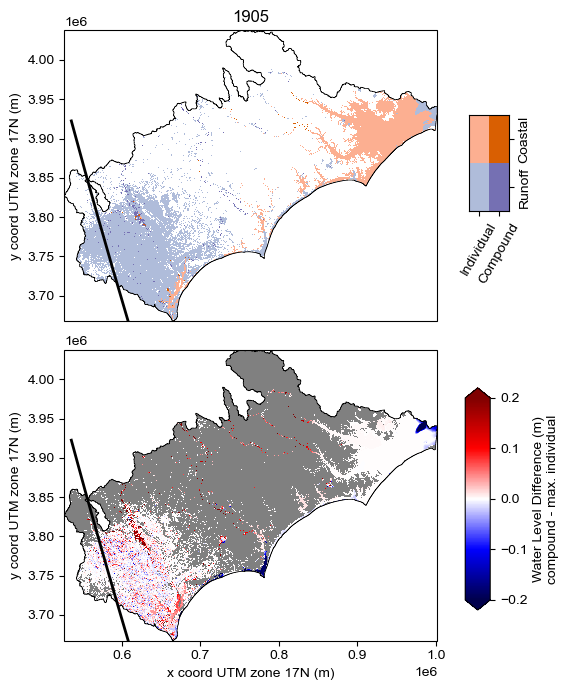

In [71]:
''' Plot 2: Peak Flood Extent Attributed '''
attr = attr_ds.sel(tc_id=tc_id)
da_diff = attr['zsmax_diff']
da_c = attr['zsmax_attr']
da_c = da_c.where(da_c > 0)

# Load CRS stuff for plotting
wkt = dem.raster.crs.to_wkt()
utm_zone = dem.raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 7), subplot_kw={'projection': utm}, 
                        tight_layout=True, sharex=True, sharey=False)
for i in range(len(axs)):
    if i == 1:
        # Plot difference in water level raster
        ckwargs = dict(cmap='seismic', vmin=-0.2, vmax=0.2)
        cs = da_diff.plot(ax=axs[i], add_colorbar=False, **ckwargs, zorder=2)
        
        # Add colorbar
        label = 'Water Level Difference (m)\ncompound - max. individual'
        pos0 = axs[i].get_position()  # get the original position
        cax = fig.add_axes([pos0.x1 + 0.02, pos0.y0 + 0.1, 0.05, pos0.height * 0.7])
        cbar = fig.colorbar(cs,
                            cax=cax,
                            orientation='vertical',
                            label=label,
                            extend='both')
        axs[i].set_title('')
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)")
        axs[i].yaxis.set_visible(True)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)")
        axs[i].xaxis.set_visible(True)
        axs[i].ticklabel_format(style='sci', useOffset=False)
        axs[i].set_aspect('equal')

        region.plot(ax=axs[i], color='grey', edgecolor='none', linewidth=0.5, zorder=1, alpha=1)
        region.plot(ax=axs[i], color='none', edgecolor='black', linewidth=0.5, zorder=2, alpha=1)
        tc_track_gdf.geometry.plot(ax=axs[i], color='black', linewidth=2, zorder=2)

    if i == 0:
        levels = np.arange(1, 8)
        colors = np.array([
            [252, 141, 98],
            [217, 95, 2],
            [141, 160, 203],
            [117, 112, 179],
            [102, 194, 165],
            [27, 158, 119],
        ]) / 255
        colors = np.hstack([colors, np.ones((6, 1))])
        colors[[0, 2, 4], -1] = 0.7
        cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)
        
        # Plot the data
        da_c.plot(ax=axs[i], cmap=cmap, norm=norm, add_colorbar=False, zorder=2)
        
        # Add colorbar
        pos1 = axs[i].get_position()  # get the original position
        cbar_ax = fig.add_axes([pos1.x1 +0.05, pos1.y0 + pos1.height * 0.4, 0.08, pos1.height])
        cm = np.arange(1, 5).reshape((2, 2))
        cbar_ax.imshow(cm, cmap=cmap, norm=norm, aspect='auto')
        cbar_ax.yaxis.tick_right()
        cbar_ax.set_yticks([0, 1])
        cbar_ax.set_yticklabels(['Coastal\n', 'Runoff\n'], va='center', rotation=90, fontsize=10)
        cbar_ax.set_xticks([0, 1])
        cbar_ax.set_xticklabels(['Individual', 'Compound'], ha='center', rotation=60, fontsize=10)
        
        # Fix titles and axis labels
        axs[i].set_title('')
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)")
        axs[i].yaxis.set_visible(True)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)")
        axs[i].xaxis.set_visible(False)
        axs[i].ticklabel_format(style='sci', useOffset=False)
        axs[i].set_aspect('equal')
        axs[i].set_title(f'{tc_id}')

        region.plot(ax=axs[i], color='white', edgecolor='none', linewidth=0.5, zorder=1, alpha=1)
        region.plot(ax=axs[i], color='none', edgecolor='black', linewidth=0.5, zorder=2, alpha=1)
        tc_track_gdf.geometry.plot(ax=axs[i], color='black', linewidth=2, zorder=2)

    # Setup figure extents
    minx, miny, maxx, maxy = region.total_bounds
    axs[i].set_xlim(minx, maxx)
    axs[i].set_ylim(miny, maxy)

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(os.path.join(runs_dir, f'TC_{str(tc_id).zfill(4)}', 'zsmax_attribution.png'), dpi=225, bbox_inches="tight")
#plt.close()